## <center>A prelude to Gaussian Processes using first principles</center>


In [38]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

$\underbrace{x_i,x_j}_{input}\rightarrow\underbrace{\mathcal{k}(x_i,x_j)}_{kernel function}\rightarrow \underbrace{\textit{how well are $f(x_i) and f(x_j)$ related?}}_{output}$

In [39]:
def kernel(xi,xj):
    sqdist = np.sum(xi**2,axis=1).reshape(-1,1)+np.sum(xj**2,axis=1)-2*np.dot(xi,xj.T)
    return np.exp(-0.5*sqdist)

In [40]:
n_testdata = 500
Xtest = np.linspace(-15,15,n_testdata).reshape(-1,1)#Return evenly spaced numbers over a specified interval.
K_ = kernel(Xtest,Xtest)#populating covariance matrix with the kernel function

In [41]:
np.random.seed(1)
n_functions = 5

### Aside: Cholesky decomposition(for Real nos)
$K=L.L^T$  
where L is lower-triangular(entries above the main diagonal are 0),  
K is positive-definite covariance matrix

In [42]:
L = np.linalg.cholesky(K_+1e-6*np.eye(n_testdata))#We add a small quantity since we invert L while modeling GP

rand_error = np.random.normal(loc=0, scale=1.0,size=(n_testdata,n_functions))

In [43]:
rand_error.shape

(500, 5)

$\underbrace{f_{prior}(\vec x)}_{\text{vector of values}}\sim \mathcal{N}(0,K)=\mathcal{N}(0,I).L$  
**Note:** The function $f(\vec x)$ which is the output is being sampled and not the input $\vec x$

In [44]:
f_prior = np.dot(L,rand_error)#compare with equation above
f_prior.shape

(500, 5)

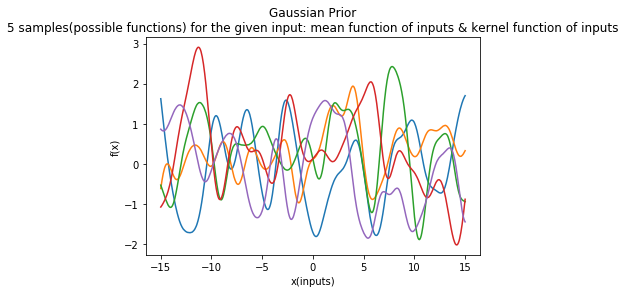

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('x(inputs)')
ax1.set_ylabel('f(x)')
ax1.set_title('Gaussian Prior'+'\n'+str(n_functions)+' samples(possible functions) for the given input: mean function of inputs & kernel function of inputs')
plt.plot(Xtest,f_prior)

## Gaussian Process regression  

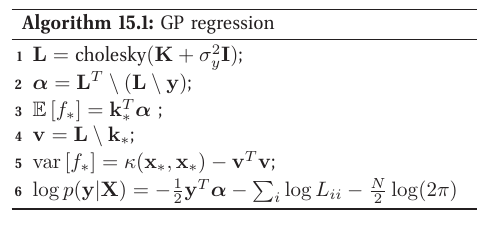

## 1. Using first principles

$\mathbb{E}[f_*] = \bf k^T_* . L^T . \big(L. y^{-1}\big)^{-1} = \bf ({L.k_*})^T . L^{-1} . y$  
$\bf k_*,y $ are vectors

#### Kernel definition

In [46]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# Define the kernel
def kernel(a, b):
    """ GP squared-exponential kernel(RBF kernel) """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)


#### True-unknown function we want too approximate.  
This is used to synthesize data--pretend we don't know

In [47]:

f = lambda x_input: np.sin(0.9*x_input).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


#### Data synthesis

In [66]:
n_train = 500      # number of training points.
n_test = 10    # number of test points.
input_data_dim = 1  # dimension of each input datum(training or test).DOESN'T WORK FOR >1
s = 0.00005    # noise variance.


# Synthesize training data(input & output)
X = np.random.uniform(-5, 5, size=(n_train,input_data_dim))#input
y = f(X) + s * np.random.randn(n_train)#output(required for evaluation of model)

# Synthesize input test data.
Xtest = np.linspace(-5, 5, n_test).reshape(-1,input_data_dim)
X.shape,y.shape,Xtest.shape

((500, 1), (500,), (10, 1))

#### Modelling using training data--only the input is used!!!

In [67]:
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(n_train))

#### Predictions for test data ' Xtest '  
np.linalg.solve(a, b) solves $A.\vec x = \vec b$, linear matrix equation for $\vec x$

In [68]:
# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))#obtained from formulae for conditional gaussian from joint gaussian
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our new-test points.
K_ = kernel(Xtest, Xtest)
vT_v = np.diag(K_) - np.sum(Lk**2, axis=0)
sdev = np.sqrt(vT_v)


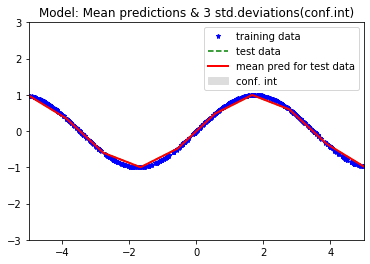

In [69]:

# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'b*', ms=5,label='training data')
pl.plot(Xtest, f(Xtest), 'g--', ms=15,label='test data')
pl.gca().fill_between(Xtest.flat, mu-3*sdev, mu+3*sdev, color="#dddddd",label='conf. int')
pl.plot(Xtest, mu, 'r-', lw=2,label='mean pred for test data')
pl.title('Model: Mean predictions & 3 std.deviations(conf.int)')
pl.axis([-5, 5, -3, 3])
pl.legend()
pl.savefig('predictive.png', bbox_inches='tight')
pl.show()

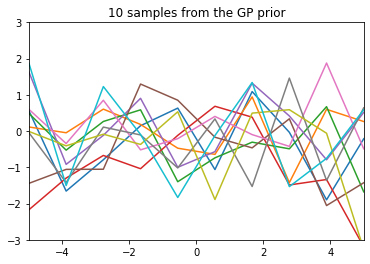

In [71]:
# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_test))
n_samples = 10
f_prior = np.dot(L, np.random.normal(size=(n_test,n_samples)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title(str(n_samples)+' samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')
pl.show()

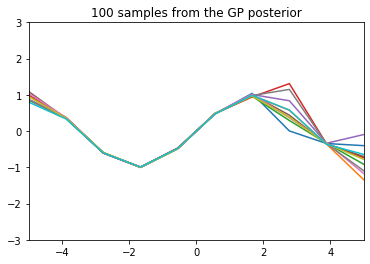

In [57]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n_test) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_test,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title(str(n_samples)+' samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')
pl.show()

In [72]:
import GPy
y=y.reshape(-1,1)
X.shape,y.shape

((500, 1), (500, 1))

## 2.Using GPy library

In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from sklearn import tree
train = pd.read_csv('./Liverpool_train.csv')
train.shape

(5000000, 3)

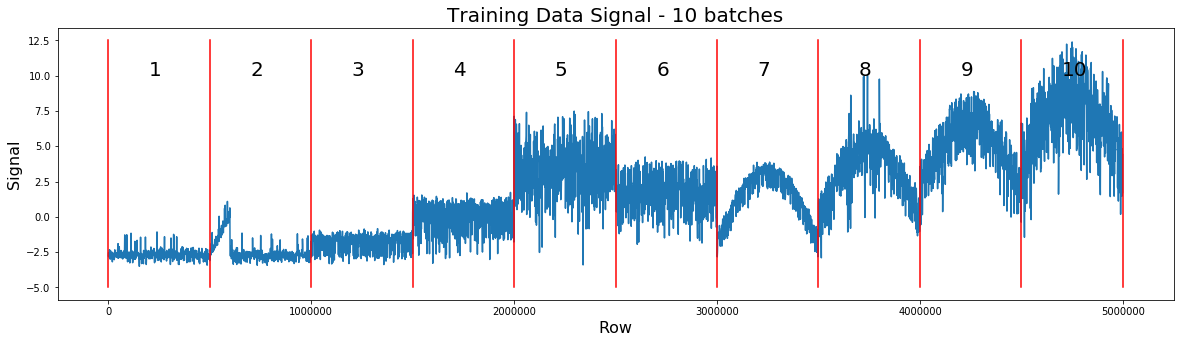

In [85]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

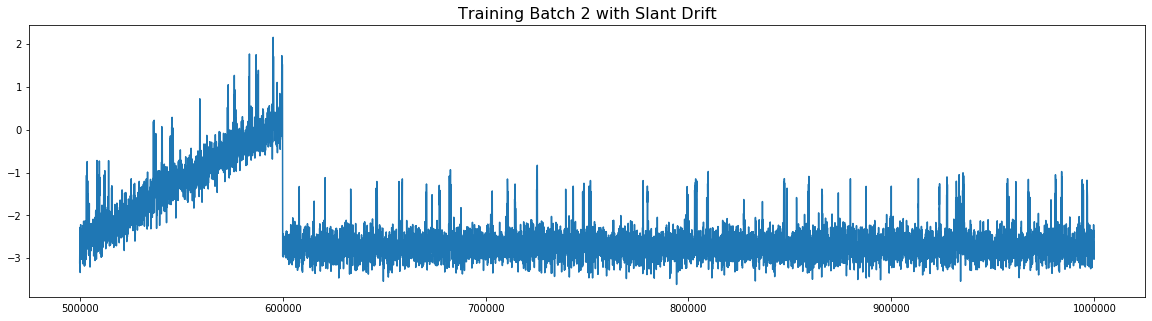

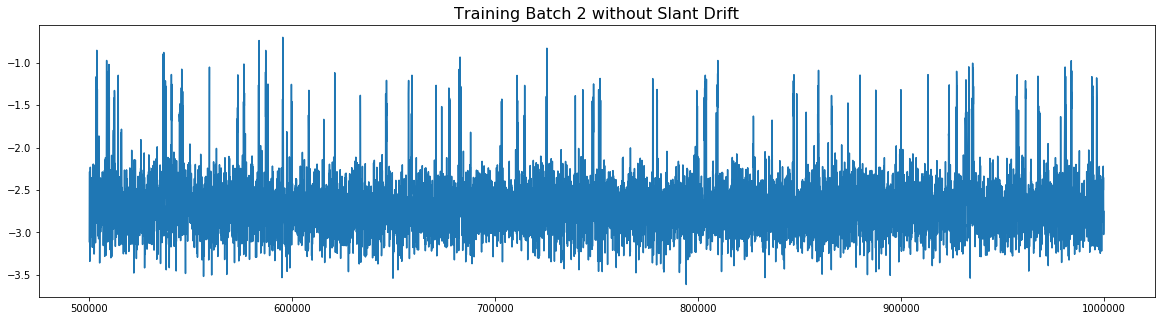

In [87]:
train2 = train.copy()

a=500000; b=600000 # CLEAN TRAIN BATCH 2
train2.loc[train.index[a:b],'signal'] = train2.signal[a:b].values - 3*(train2.time.values[a:b] - 50)/10.
batch=2; a=500000*(batch-1); b=500000*batch; res=50
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train.signal[a:b][0::res])
plt.title('Training Batch 2 with Slant Drift',size=16)
plt.figure(figsize=(20,5))
plt.plot(range(a,b,res),train2.signal[a:b][0::res])
plt.title('Training Batch 2 without Slant Drift',size=16)
plt.show()

In [88]:
batch = 1; a = 500000*(batch-1); b = 500000*batch
batch = 2; c = 500000*(batch-1); d = 500000*batch
X_train = np.concatenate([train2.signal.values[a:b],train2.signal.values[c:d]]).reshape((-1,1))
y_train = np.concatenate([train2.open_channels.values[a:b],train2.open_channels.values[c:d]]).reshape((-1,1))


In [97]:
m = GPy.models.GPRegression(X_train[:500000],y_train[:500000])

MemoryError: 

In [73]:
import GPy
y=y.reshape(-1,1)
X.shape,y.shape
m = GPy.models.GPRegression(X=X,Y=y)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f74ef08c550>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f74ef08c940>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f74ef08cda0>]]}

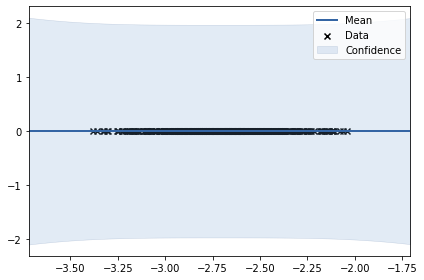

In [93]:
m.plot()

In [96]:
(m.predict(X_train[500:1000])[0] - y_train[500:1000])

array([0.])

In [75]:
mu#from the first principles

array([ 0.97667423,  0.35083231, -0.59848137, -0.99747702, -0.47942274,
        0.47944509,  0.99749757,  0.5984845 , -0.35078859, -0.97631573])

## <center>Bayesian optimisation</center>  
<i><center>A saga of choosing between <b>Exploration</b> and <b>Exploitation</b></center></i>

The next candidate $\pmb\theta$(hyperparameters) is chosen such that mean is high(*exploitation*) and variance is high(*exploration*).
This tradeoff is balanced by an **acquisition function**, given by $\mu(\theta)+\mathcal{k}.\sigma(\theta)$  
If exploitation $\longrightarrow$ small '$\mathcal{k}$'  
If exploration $\longrightarrow$ large '$\mathcal{k}$'

In [147]:
!python3 -m pip install bayesian-optimization --user

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-py3-none-any.whl size=10031 sha256=199d240b671492766d6e8d09e9fd7ac9056c25808339784305f436b601e41133
  Stored in directory: /home/nizam/.cache/pip/wheels/be/4b/0a/70d8dc561c3fe0dd78e7fefdb48b3cfda924f275a177efd0c9
Successfully built bayesian-optimization


In [155]:

import numpy as np

def objective(x,y):
    return -x ** 2 - (y - 1) ** 2 + 1

In [156]:
from bayes_opt import BayesianOptimization

In [161]:
pbounds = {'x': (2, 4), 'y': (-3, 3)}#2 dimensional function optimization.

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=3,
)

print(optimizer.max)


|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |
|  3        | -19.0     |  4.0      |  3.0      |
|  4        | -16.3     |  2.378    | -2.413    |
|  5        | -4.441    |  2.105    | -0.005822 |
{'target': -4.441293113411222, 'params': {'x': 2.104665051994087, 'y': -0.005822117636089974}}


In [160]:
#Used to specifically inform the algorithm to evaluate objective function at the values provided
optimizer.probe(
    params={"x": 2.5, "y": 2.7},
    lazy=True
)

In [162]:
print('The parameters being optimized are',optimizer.space.keys)


The parameters being optimized are ['x', 'y']


In [164]:
#Saving optimizer
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
logger = JSONLogger(path="./firstlog.json")
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)
optimizer.maximize(init_points=2,n_iter=3)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  6        | -16.13    |  2.294    | -2.446    |
|  7        | -8.341    |  2.373    | -0.9266   |
|  8        | -4.616    |  2.234    |  0.2096   |
|  9        | -3.658    |  2.0      |  0.189    |
|  10       | -3.399    |  2.0      |  0.3686   |


In [170]:
#Loading optimizer into a new BayesianOptimization object
from bayes_opt.util import load_logs
new_optimizer = BayesianOptimization(
    f=objective,
    pbounds={"x": (-2, 2), "y": (-2, 2)},
    verbose=2,
    random_state=7,
)
print(len(new_optimizer.space))
load_logs(new_optimizer, logs=["./firstlog.json"]);
print(len(new_optimizer.space))

0
5


In [23]:
import pandas as pd
rejected=pd.read_csv('./submission.csv',index_col='qa_id')

rejected.shape

(476, 30)

In [24]:
for column in rejected.columns:
    print(column,":",sum(rejected[column].between(0,1)))

question_asker_intent_understanding : 476
question_body_critical : 476
question_conversational : 476
question_expect_short_answer : 476
question_fact_seeking : 476
question_has_commonly_accepted_answer : 476
question_interestingness_others : 476
question_interestingness_self : 476
question_multi_intent : 476
question_not_really_a_question : 476
question_opinion_seeking : 476
question_type_choice : 476
question_type_compare : 476
question_type_consequence : 476
question_type_definition : 476
question_type_entity : 476
question_type_instructions : 476
question_type_procedure : 476
question_type_reason_explanation : 476
question_type_spelling : 476
question_well_written : 476
answer_helpful : 476
answer_level_of_information : 476
answer_plausible : 476
answer_relevance : 476
answer_satisfaction : 476
answer_type_instructions : 476
answer_type_procedure : 476
answer_type_reason_explanation : 476
answer_well_written : 476


In [25]:
rejected.isnull().sum()/len(df)


question_asker_intent_understanding      0.0
question_body_critical                   0.0
question_conversational                  0.0
question_expect_short_answer             0.0
question_fact_seeking                    0.0
question_has_commonly_accepted_answer    0.0
question_interestingness_others          0.0
question_interestingness_self            0.0
question_multi_intent                    0.0
question_not_really_a_question           0.0
question_opinion_seeking                 0.0
question_type_choice                     0.0
question_type_compare                    0.0
question_type_consequence                0.0
question_type_definition                 0.0
question_type_entity                     0.0
question_type_instructions               0.0
question_type_procedure                  0.0
question_type_reason_explanation         0.0
question_type_spelling                   0.0
question_well_written                    0.0
answer_helpful                           0.0
answer_lev

## References:  
1)https://www.cs.ubc.ca/~nando/540-2013/lectures  
2)https://www.cs.ubc.ca/~murphyk/MLbook/